# Predict volume area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.models.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [48]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='v', path=data_path/'AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [49]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [50]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [51]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [52]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [53]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.002511886414140463)

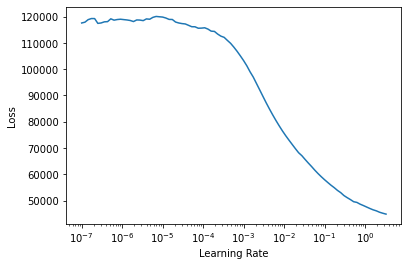

In [54]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,103622.687500,95274.750000,308.666046,204.728287,296.486969,196.650299,298.601654,-9.468830,00:00
1,67792.937500,17876.328125,133.702393,88.680511,97.756813,64.838966,116.178001,-0.964259,00:00
2,40012.492188,3003.474365,54.803963,36.349712,13.598287,9.019307,38.162964,0.669977,00:00
3,25608.246094,2287.800537,47.830959,31.724743,3.597309,2.385980,33.042458,0.748615,00:00
4,17497.048828,2237.216553,47.299225,31.372059,8.285906,5.495776,32.470200,0.754174,00:00
5,12436.428711,1781.451416,42.207245,27.994713,4.465552,2.961857,30.362698,0.804253,00:00
6,9102.534180,1715.989136,41.424500,27.475542,0.079008,0.052403,29.939816,0.811446,00:00
7,6806.212891,1675.361938,40.931187,27.148346,3.304564,2.191811,29.391481,0.815911,00:00
8,5208.867676,1686.342529,41.065102,27.237165,5.032578,3.337948,29.563513,0.814704,00:00
9,4084.758545,1670.866211,40.876232,27.111895,2.558205,1.696776,29.417871,0.816405,00:00


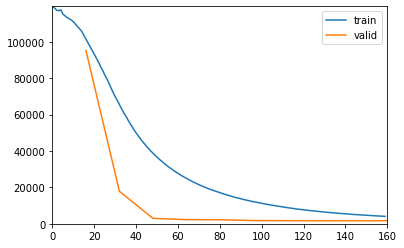

In [55]:
learn.fit_one_cycle(10, max_lr=1e-2, cbs=ShowGraphCallback())

In [56]:
preds, true = learn.get_preds()

In [57]:
preds.shape

torch.Size([225, 1])

See validation results

In [58]:
learn.validate()

(#7) [1670.8662109375,40.8762321472168,27.111894607543945,2.5582053661346436,1.6967756748199463,29.417871475219727,0.8164045033967208]

`RegressionInterpretation` can be used to plot results.

In [59]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

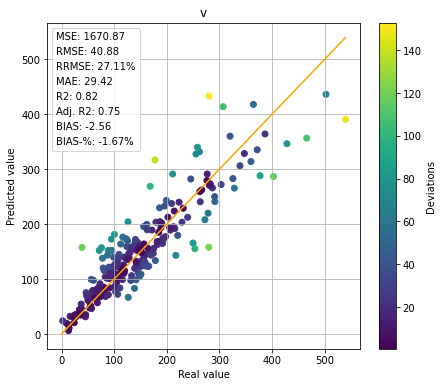

In [60]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [61]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [62]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

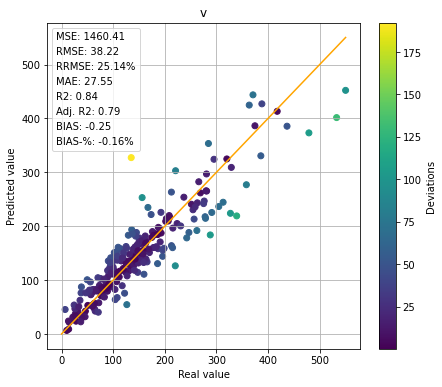

In [63]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [64]:
ensemble = tabular_ensemble(dls, 
                       y_range=(0,1000), 
                
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10)

In [65]:
ensemble.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,150204.203125,118314.757812,343.969147,228.143723,335.680420,222.646072,335.680420,-12.000476,00:00
1,102918.109375,33107.035156,181.953400,120.683861,139.078537,92.246338,161.792953,-2.637816,00:00
2,62341.250000,6370.826172,79.817459,52.940361,43.729336,29.004267,59.170559,0.299971,00:00
3,39759.613281,2726.275391,52.213741,34.631702,4.739119,3.143306,37.230331,0.700436,00:00
4,26859.281250,2517.844971,50.178135,33.281551,8.350918,5.538896,34.541706,0.723338,00:00
5,18877.048828,2200.855713,46.913280,31.116074,-2.117134,-1.404227,33.143612,0.758169,00:00
6,13690.368164,2935.408691,54.179413,35.935467,17.151972,11.376353,35.988026,0.677456,00:00
7,10151.263672,1802.923584,42.460846,28.162918,0.881966,0.584980,30.151337,0.801894,00:00
8,7682.562988,1777.892944,42.165062,27.966734,3.107307,2.060977,29.853903,0.804644,00:00
9,5925.761230,1802.996704,42.461712,28.163492,4.711102,3.124723,29.919847,0.801886,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,1685.366577,1661.867065,40.766003,27.038782,2.779842,1.843780,28.531574,0.817393,00:00
1,1648.396973,1675.897583,40.937725,27.152681,5.308228,3.520777,27.777884,0.815852,00:00
2,1620.137085,1878.195312,43.338150,28.744804,-6.057193,-4.017542,30.083509,0.793623,00:00
3,1535.398926,1496.315674,38.682240,25.656689,10.595498,7.027654,27.046387,0.835584,00:00
4,1441.192017,1750.575562,41.839878,27.751049,12.080876,8.012858,28.394072,0.807646,00:00
5,1369.209229,1690.794434,41.119274,27.273098,12.839072,8.515745,28.095266,0.814215,00:00
6,1405.810303,1340.510254,36.612980,24.284216,3.498313,2.320319,25.410084,0.852704,00:00
7,1329.987549,1408.857544,37.534748,24.895596,3.484744,2.311319,26.715736,0.845194,00:00
8,1243.909180,1342.506348,36.640228,24.302288,0.664972,0.441055,25.616711,0.852485,00:00
9,1174.548828,1371.511353,37.033920,24.563412,-0.765934,-0.508019,25.830946,0.849298,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,881.797424,1677.006714,40.951275,27.161667,13.071043,8.669603,27.864777,0.815730,00:00
1,919.793701,1355.770508,36.820786,24.422047,-0.830253,-0.550680,25.896446,0.851027,00:00
2,1098.956177,1435.033936,37.881844,25.125813,-7.639257,-5.066875,26.671926,0.842318,00:00
3,1229.997192,1561.453003,39.515224,26.209181,-6.946378,-4.607310,27.995152,0.828427,00:00
4,1154.554077,1588.345337,39.854046,26.433912,6.560134,4.351126,26.519522,0.825472,00:00
5,1087.395630,1520.771118,38.997066,25.865503,10.386675,6.889148,26.586527,0.832897,00:00
6,1045.587646,1438.833862,37.931965,25.159056,3.317865,2.200633,26.456392,0.841900,00:00
7,958.591309,1388.617676,37.264164,24.716125,3.649852,2.420830,25.979591,0.847418,00:00
8,919.623047,1365.245117,36.949226,24.507238,1.975572,1.310334,25.905403,0.849986,00:00
9,846.003418,1365.845093,36.957344,24.512621,3.344747,2.218463,25.876581,0.849920,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,722.868347,1514.678589,38.918873,25.813643,7.728534,5.126089,26.539154,0.833566,00:00
1,797.213440,1437.955566,37.920383,25.151375,8.506023,5.641773,26.415222,0.841997,00:00
2,817.364197,2038.768188,45.152721,29.948353,18.701193,12.403902,30.496374,0.775979,00:00
3,962.673157,2091.004639,45.727505,30.329588,-3.978646,-2.638908,30.751137,0.770240,00:00
4,967.000244,1520.521606,38.993866,25.863382,2.351977,1.559991,26.867878,0.832924,00:00
5,881.042053,1566.415649,39.577969,26.250797,7.822575,5.188463,27.020096,0.827882,00:00
6,878.921570,1540.322510,39.246941,26.031239,11.821696,7.840952,26.992058,0.830749,00:00
7,843.075195,1636.175659,40.449665,26.828966,-2.820441,-1.870708,27.601677,0.820216,00:00
8,807.162659,1363.674438,36.927959,24.493132,-0.230941,-0.153176,25.394245,0.850159,00:00
9,737.769165,1359.296509,36.868637,24.453785,1.537286,1.019632,25.381962,0.850640,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,719.491516,1331.415039,36.488560,24.201693,0.538931,0.357456,25.262024,0.853704,00:00
1,798.781433,1336.913696,36.563835,24.251621,5.294687,3.511796,25.340353,0.853099,00:00
2,828.352722,1464.902588,38.274048,25.385948,-0.016342,-0.010839,26.065414,0.839036,00:00
3,861.397522,1763.726196,41.996738,27.855089,-10.394792,-6.894532,28.223377,0.806201,00:00
4,876.386169,1368.559204,36.994041,24.536961,2.841912,1.884949,26.122585,0.849622,00:00
5,775.762024,1501.204346,38.745380,25.698570,5.445470,3.611806,26.725460,0.835047,00:00
6,723.812744,1454.110718,38.132805,25.292269,1.192578,0.790999,26.200825,0.840222,00:00
7,682.769531,1386.874390,37.240761,24.700603,3.553009,2.356597,25.809780,0.847610,00:00
8,636.112305,1309.844482,36.191776,24.004845,0.569287,0.377590,24.848181,0.856074,00:00
9,607.942322,1323.500854,36.379951,24.129656,3.401556,2.256143,25.135078,0.854573,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,690.058655,1298.576782,36.035770,23.901371,5.139105,3.408604,25.071398,0.857312,00:00
1,642.541748,1512.680054,38.893185,25.796600,9.932153,6.587678,27.396889,0.833786,00:00
2,728.230530,2273.294189,47.679077,31.624004,-10.660221,-7.070583,30.549149,0.750209,00:00
3,708.484253,1396.737671,37.372955,24.788282,0.575952,0.382010,25.168108,0.846526,00:00
4,716.260254,1730.018799,41.593494,27.587631,7.261439,4.816279,28.389706,0.809905,00:00
5,733.203003,1378.893799,37.133457,24.629433,2.843293,1.885865,25.363997,0.848487,00:00
6,668.558411,1396.495605,37.369717,24.786135,1.016929,0.674497,25.562750,0.846552,00:00
7,612.826294,1480.559570,38.478039,25.521248,0.716932,0.475518,26.619188,0.837315,00:00
8,594.408691,1420.026001,37.683231,24.994080,4.380037,2.905138,26.304623,0.843967,00:00
9,548.277039,1386.350220,37.233730,24.695940,1.150163,0.762866,25.534573,0.847667,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,488.189484,1400.300415,37.420586,24.819874,4.622324,3.065839,25.969517,0.846134,00:00
1,500.118439,1493.976929,38.651997,25.636631,6.585656,4.368054,26.726866,0.835841,00:00
2,534.764221,1924.528564,43.869450,29.097198,-6.399771,-4.244763,28.825726,0.788532,00:00
3,616.837280,1670.101196,40.866875,27.105690,6.550404,4.344673,28.113920,0.816489,00:00
4,613.263428,1249.709106,35.351227,23.447336,1.143423,0.758396,24.934845,0.862681,00:00
5,629.437073,2063.984619,45.431099,30.132992,-7.929991,-5.259709,30.549417,0.773208,00:00
6,661.794006,1454.061523,38.132156,25.291836,-2.940782,-1.950526,25.836348,0.840227,00:00
7,608.870728,1341.109497,36.621162,24.289644,4.095335,2.716305,25.880447,0.852638,00:00
8,563.586609,1414.234131,37.606304,24.943056,1.020747,0.677029,26.086145,0.844603,00:00
9,523.032043,1379.311890,37.139088,24.633165,0.699250,0.463790,25.717276,0.848441,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,403.268890,1379.445923,37.140892,24.634363,-1.472785,-0.976851,25.210234,0.848426,00:00
1,414.617645,1357.891724,36.849586,24.441151,1.971533,1.307655,25.926712,0.850794,00:00
2,498.553864,1571.276123,39.639324,26.291492,10.030800,6.653108,28.190790,0.827348,00:00
3,494.435272,1591.373901,39.892029,26.459105,8.193417,5.434431,28.962667,0.825139,00:00
4,564.415955,1600.334351,40.004181,26.533491,10.002419,6.634284,28.723125,0.824155,00:00
5,620.891479,1688.584595,41.092392,27.255266,1.455118,0.965133,28.823832,0.814458,00:00
6,621.561157,1660.631714,40.750851,27.028734,4.761333,3.158040,28.518719,0.817529,00:00
7,580.519409,1630.427002,40.378548,26.781797,0.641317,0.425365,27.929224,0.820848,00:00
8,542.850037,1487.852173,38.572685,25.584024,-0.469879,-0.311655,26.159948,0.836514,00:00
9,498.091675,1495.036133,38.665699,25.645718,0.551495,0.365789,26.258169,0.835725,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,501.399323,1635.369873,40.439709,26.822361,0.473661,0.314164,27.723068,0.820305,00:00
1,446.287567,1975.918091,44.451302,29.483124,-3.608853,-2.393637,29.696983,0.782885,00:00
2,482.176147,1688.427734,41.090485,27.254000,1.770888,1.174573,28.036381,0.814475,00:00
3,491.058411,1544.669312,39.302284,26.067945,2.937232,1.948172,27.916862,0.830271,00:00
4,495.494049,1633.745239,40.419613,26.809034,3.350405,2.222216,27.935883,0.820483,00:00
5,582.884521,1704.204956,41.282017,27.381039,3.181261,2.110028,29.088221,0.812741,00:00
6,564.525208,1554.080322,39.421825,26.147234,-0.537346,-0.356404,26.408792,0.829237,00:00
7,519.126282,1418.858521,37.667740,24.983805,0.522386,0.346482,25.654266,0.844095,00:00
8,483.399963,1412.870605,37.588169,24.931026,0.761446,0.505043,26.036921,0.844753,00:00
9,444.697235,1386.311768,37.233208,24.695593,1.820520,1.207493,25.812023,0.847671,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,348.190552,1420.393311,37.688103,24.997311,3.113488,2.065077,25.952284,0.843927,00:00
1,375.015747,1500.038696,38.730331,25.688589,3.647112,2.419012,26.867193,0.835175,00:00
2,563.648560,1493.152100,38.641323,25.629551,-0.476348,-0.315946,27.540340,0.835932,00:00
3,540.027283,1472.171265,38.368885,25.448853,0.634125,0.420595,26.347561,0.838237,00:00
4,552.447205,1561.907959,39.520985,26.213001,8.037597,5.331080,27.344988,0.828377,00:00
5,570.610718,1493.570557,38.646740,25.633144,4.535589,3.008311,26.530657,0.835886,00:00
6,493.615875,1426.128662,37.764118,25.047728,1.339753,0.888615,25.858505,0.843296,00:00
7,475.176636,1539.600464,39.237740,26.025135,0.816368,0.541471,26.969473,0.830828,00:00
8,428.805359,1475.157959,38.407784,25.474653,-1.751448,-1.161679,26.164961,0.837909,00:00
9,410.534668,1425.433594,37.754913,25.041624,-0.780218,-0.517494,25.861107,0.843373,00:00


In [66]:
res = ensemble.validate()

See ensemble validation results.

In [67]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,37.754913,25.041624,-0.780217,-0.517493,25.861105,0.843373
1,0,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
2,1,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
3,2,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
4,3,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
5,4,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
6,5,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
7,6,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
8,7,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373
9,8,37.754913,25.041624,-0.780218,-0.517494,25.861103,0.843373


In [68]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

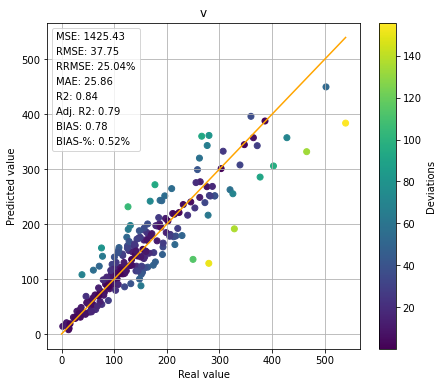

In [69]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [70]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,40.542042,26.670002,-1.599314,-1.052086,25.934576,0.825337
1,0,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
2,1,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
3,2,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
4,3,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
5,4,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
6,5,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
7,6,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
8,7,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337
9,8,40.542042,26.670002,-1.599315,-1.052086,25.934576,0.825337


In [71]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

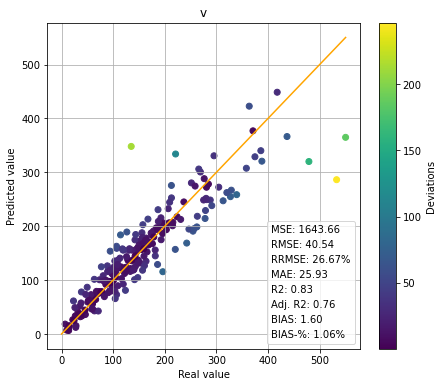

In [72]:
test_ens_interp.plot_results()
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [73]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [74]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [75]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [76]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

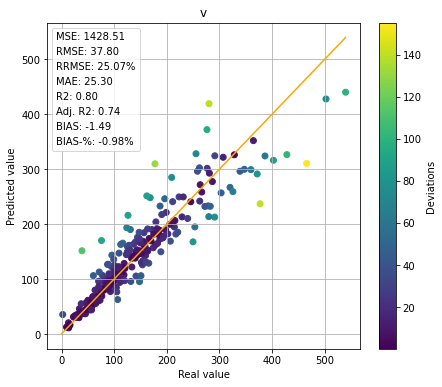

In [77]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test results

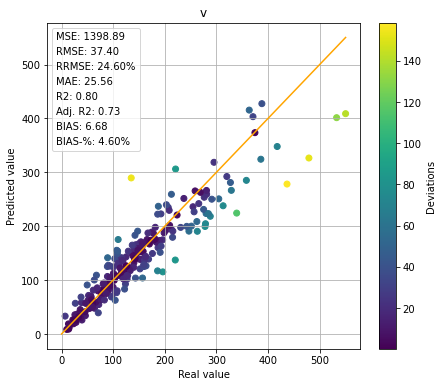

In [78]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()